In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import yfinance as yf
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [2]:

ticker = yf.Ticker("MSFT")

In [3]:

start_date = "2016-06-14"

In [4]:

df = ticker.history(start=start_date, end=None)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,44.892187,45.072113,44.595303,44.829212,42577100,0.0,0.0
2016-06-15 00:00:00-04:00,44.784227,45.090105,44.703259,44.703259,33757600,0.0,0.0
2016-06-16 00:00:00-04:00,44.550323,45.404985,44.541325,45.333012,31188600,0.0,0.0
2016-06-17 00:00:00-04:00,45.350997,45.368990,44.820208,45.099098,45710500,0.0,0.0
2016-06-20 00:00:00-04:00,45.557920,45.728855,45.009138,45.045124,35607900,0.0,0.0


In [6]:

candlestick_trace = go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick'
)

In [7]:

layout = go.Layout(
    title='MSFT Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

In [8]:

fig = go.Figure(data=[candlestick_trace], layout=layout)


fig.update_layout(xaxis_rangeslider_visible=False)

fig.show()

In [9]:

col_close = df.pop('Close')
df.insert(0, 'Close', col_close)
df.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,44.912109,44.975201,45.155459,44.677768,42577100,0.0,0.0
2016-06-15 00:00:00-04:00,44.785938,44.867056,45.173501,44.785938,33757600,0.0,0.0
2016-06-16 00:00:00-04:00,45.416836,44.632700,45.488942,44.623685,31188600,0.0,0.0
2016-06-17 00:00:00-04:00,45.182510,45.434875,45.452902,44.903104,45710500,0.0,0.0
2016-06-20 00:00:00-04:00,45.128414,45.642159,45.813409,45.092361,35607900,0.0,0.0


In [10]:
df.tail()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-01-08 00:00:00-05:00,374.690002,369.299988,375.200012,369.010010,23134000,0.0,0.0
2024-01-09 00:00:00-05:00,375.790009,372.010010,375.989990,371.190002,20830000,0.0,0.0
2024-01-10 00:00:00-05:00,382.769989,376.369995,384.170013,376.320007,25514200,0.0,0.0
2024-01-11 00:00:00-05:00,384.630005,386.000000,390.679993,380.380005,27850800,0.0,0.0
2024-01-12 00:00:00-05:00,388.470001,385.489990,388.679993,384.649994,21645700,0.0,0.0


In [11]:
df.shape

(1909, 7)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1909 entries, 2016-06-14 00:00:00-04:00 to 2024-01-12 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1909 non-null   float64
 1   Open          1909 non-null   float64
 2   High          1909 non-null   float64
 3   Low           1909 non-null   float64
 4   Volume        1909 non-null   int64  
 5   Dividends     1909 non-null   float64
 6   Stock Splits  1909 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 119.3 KB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,1909.0,1.795947e+02,9.673419e+01,4.365027e+01,9.044364e+01,1.676672e+02,2.612202e+02,3.884700e+02
Open,1909.0,1.795296e+02,9.668514e+01,4.409191e+01,9.043066e+01,1.677212e+02,2.604643e+02,3.860000e+02
High,1909.0,1.813340e+02,9.769385e+01,4.429921e+01,9.116576e+01,1.689426e+02,2.640183e+02,3.906800e+02
Low,1909.0,1.776746e+02,9.567104e+01,4.329876e+01,8.922414e+01,1.645797e+02,2.582711e+02,3.846500e+02
Volume,1909.0,2.867856e+07,1.245328e+07,7.425600e+06,2.086030e+07,2.564550e+07,3.277020e+07,1.335030e+08
Dividends,1909.0,8.208486e-03,6.637465e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.500000e-01
Stock Splits,1909.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [14]:
df.isna().sum().to_frame(name='num_of_NaN')

,num_of_NaN
Close,0
Open,0
High,0
Low,0
Volume,0
Dividends,0
Stock Splits,0


In [15]:
df.duplicated().sum()

0

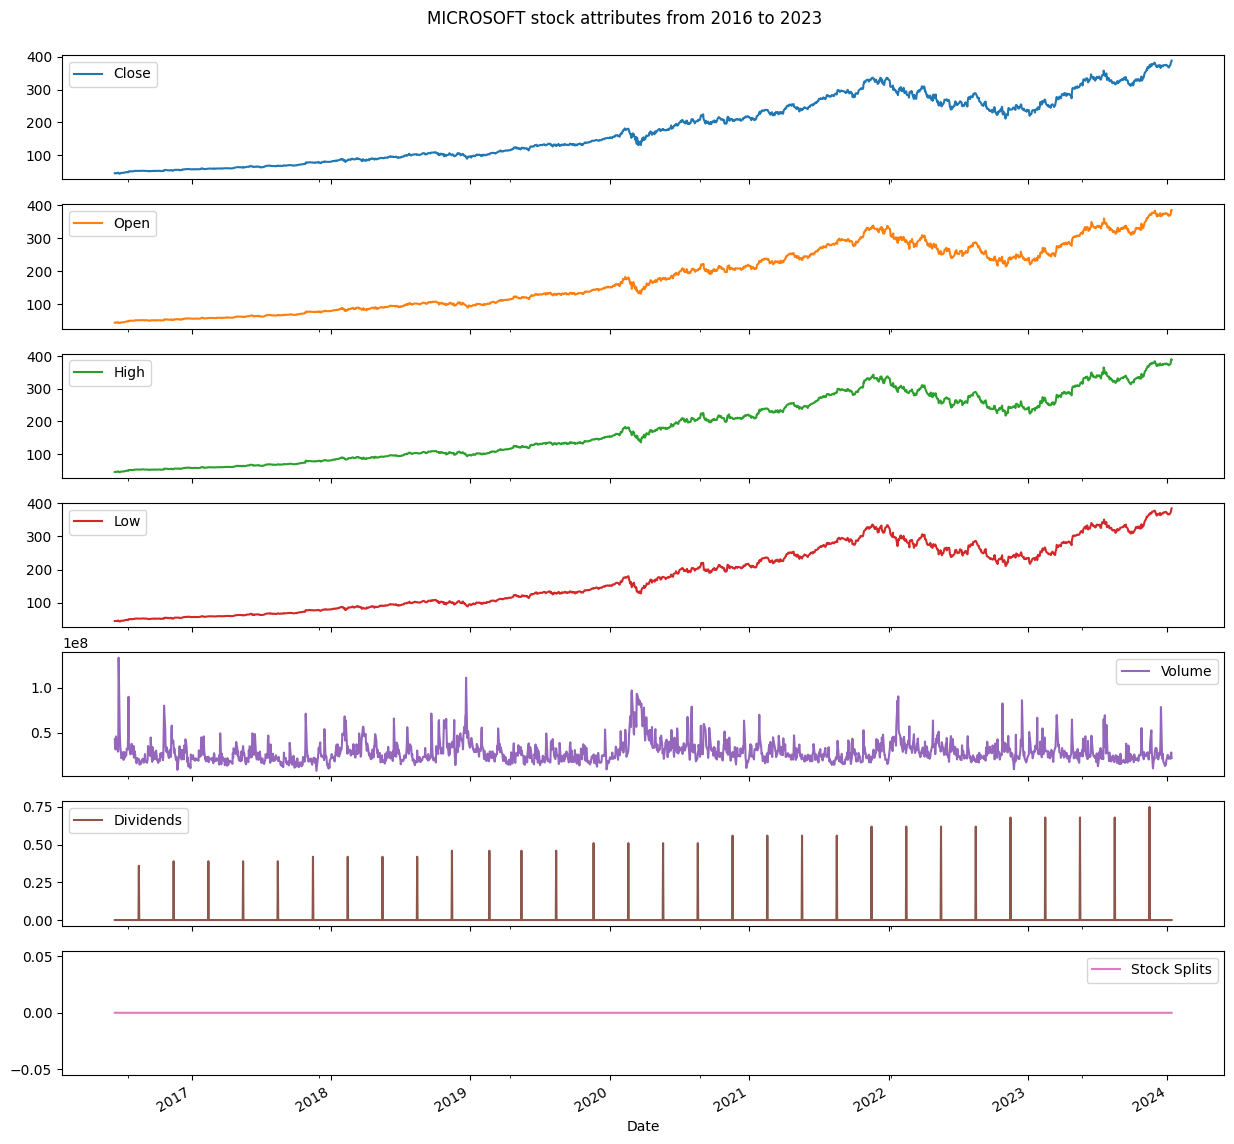

In [17]:
df.plot(subplots=True, figsize=(15, 15))
plt.suptitle('MICROSOFT stock attributes from 2016 to 2023', y=0.91)
plt.show()

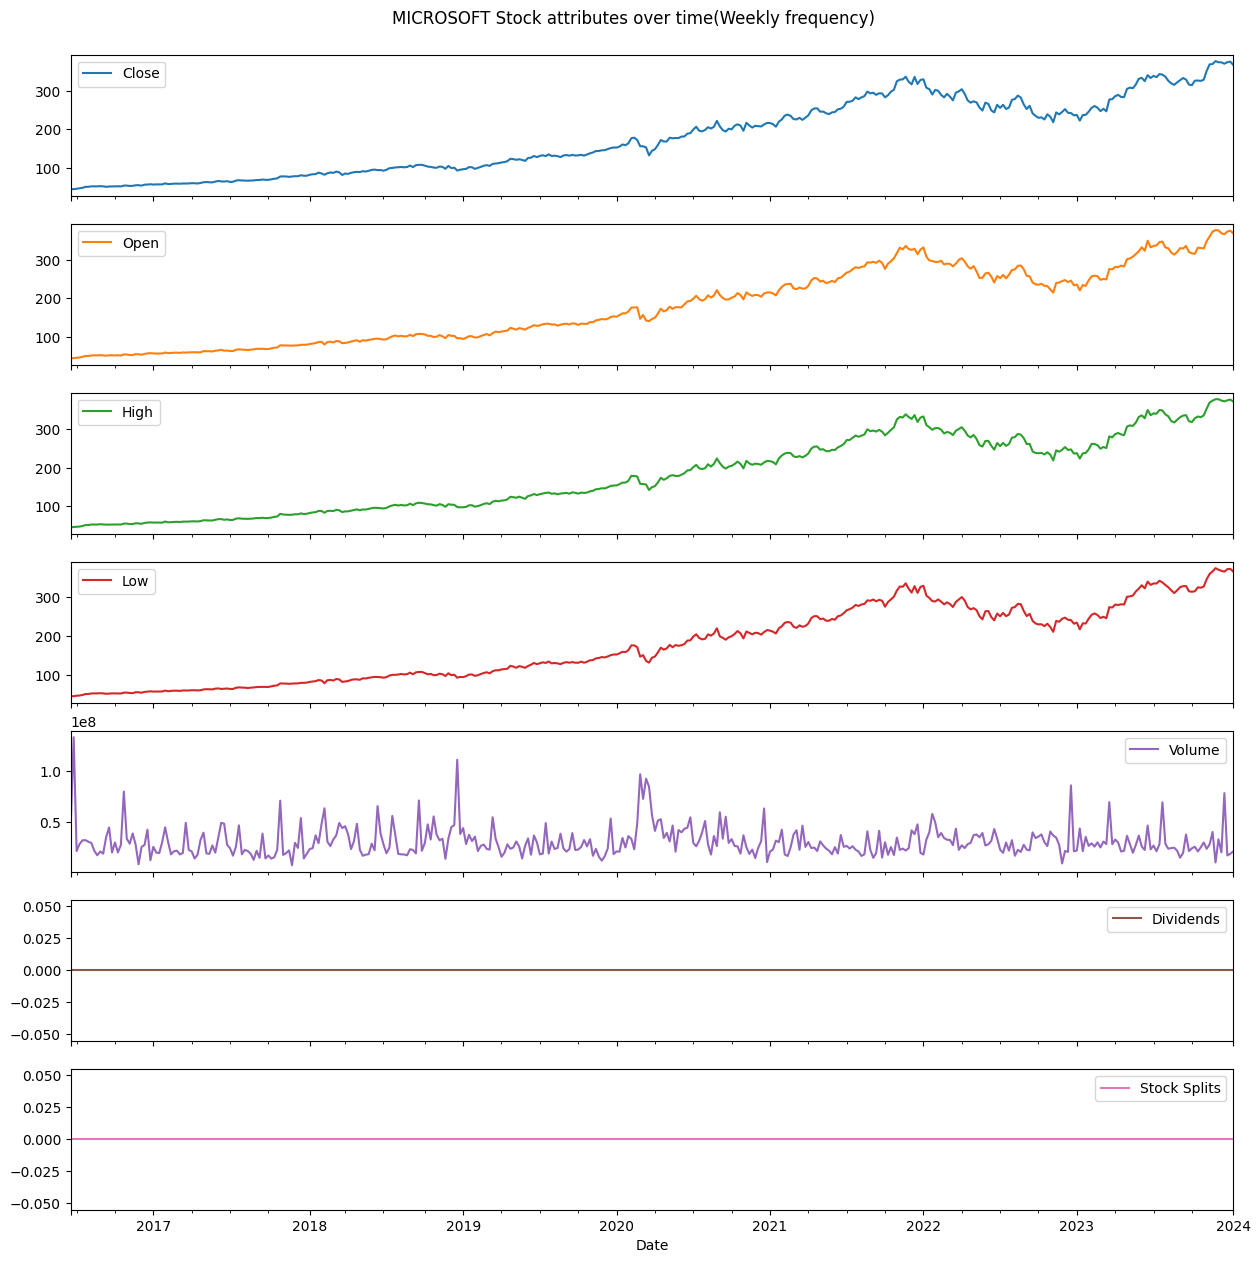

In [18]:
df.asfreq('W', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('MICROSOFT Stock attributes over time(Weekly frequency)', y=0.91)
plt.show()

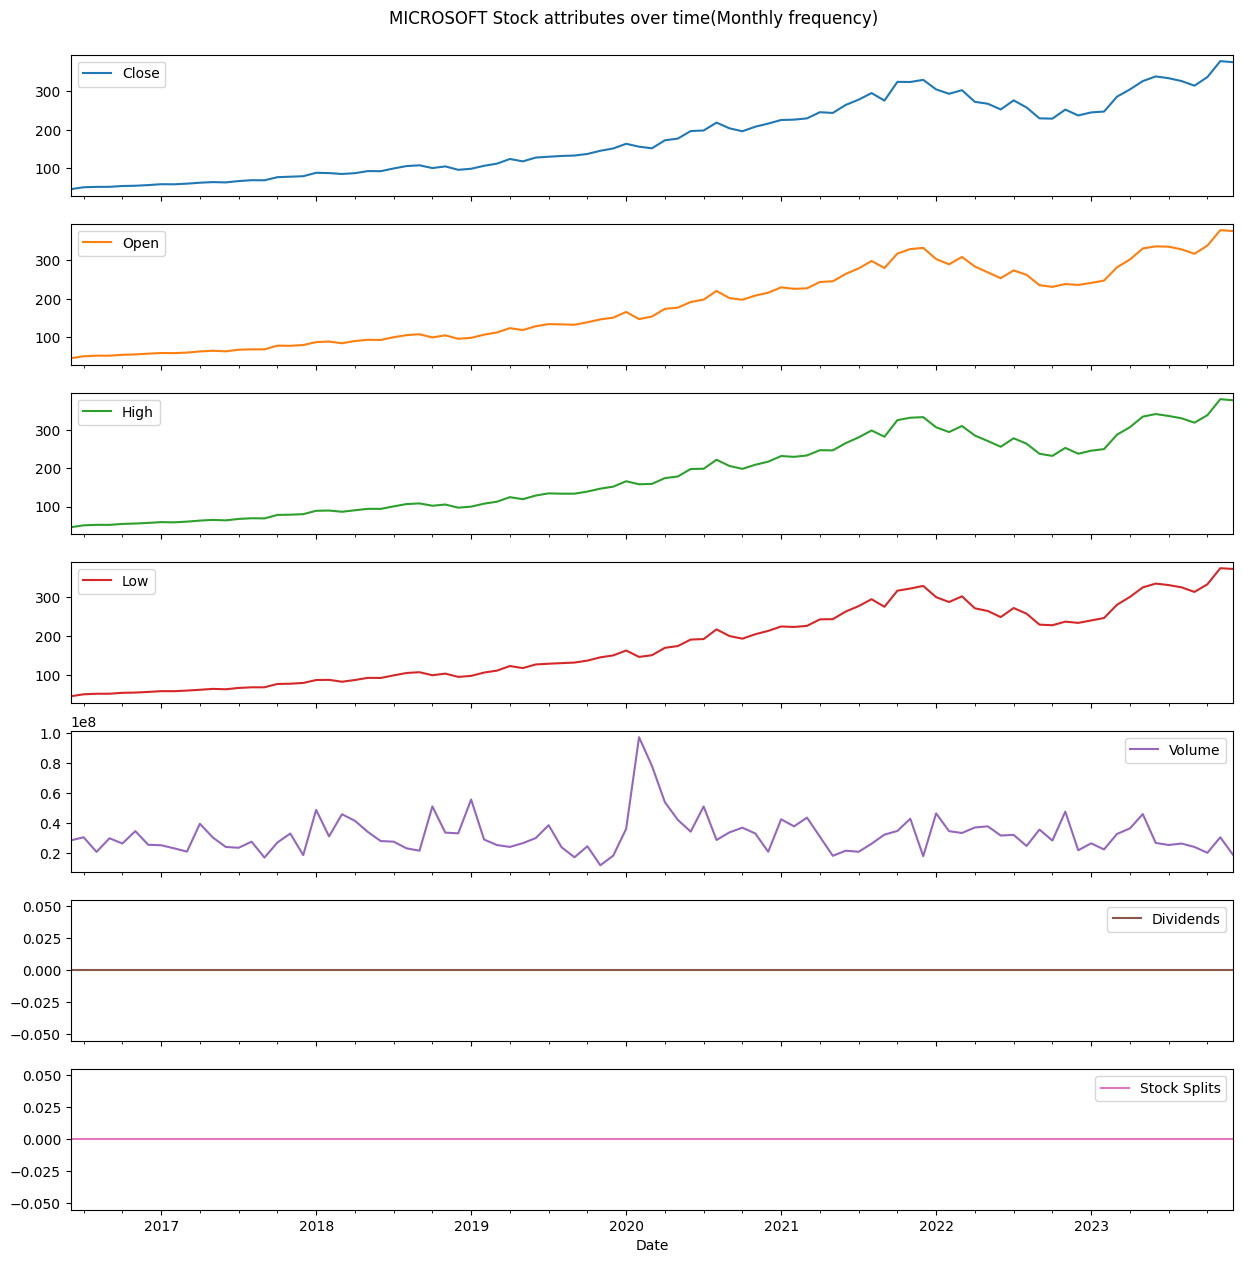

In [19]:
df.asfreq('M', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('MICROSOFT Stock attributes over time(Monthly frequency)', y=0.91)
plt.show()

In [20]:
df[['Close']]

,Close
Date,
2016-06-14 00:00:00-04:00,44.912109
2016-06-15 00:00:00-04:00,44.785938
2016-06-16 00:00:00-04:00,45.416836
2016-06-17 00:00:00-04:00,45.182510
2016-06-20 00:00:00-04:00,45.128414
...,...
2024-01-08 00:00:00-05:00,374.690002
2024-01-09 00:00:00-05:00,375.790009
2024-01-10 00:00:00-05:00,382.769989


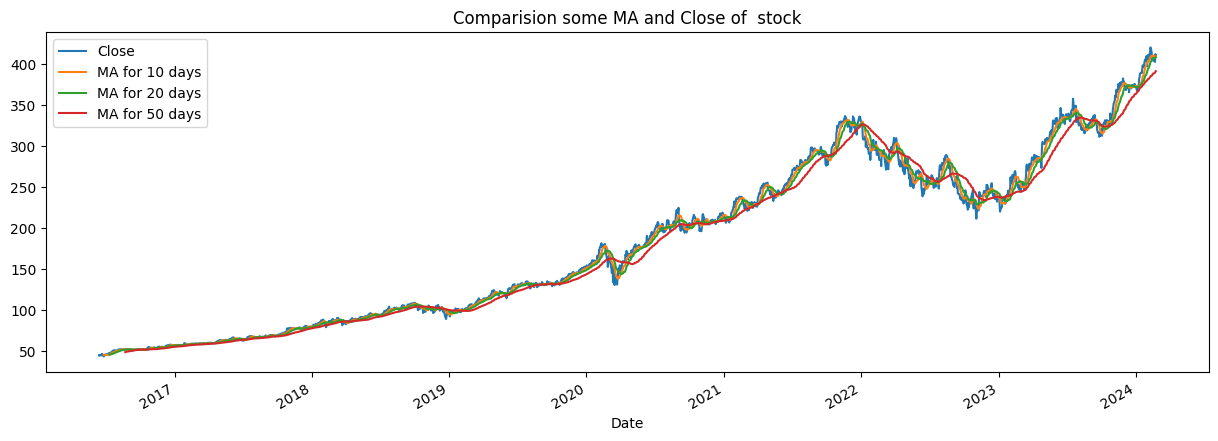

In [5]:
# computing moving average(ma)
ma_day = [10, 20, 50]

for ma in ma_day:
    col_name = f'MA for {ma} days'
    df[col_name] = df['Close'].rolling(ma).mean()

df[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(figsize=(15,5))
plt.title('Comparision some MA and Close of  stock')
plt.show()

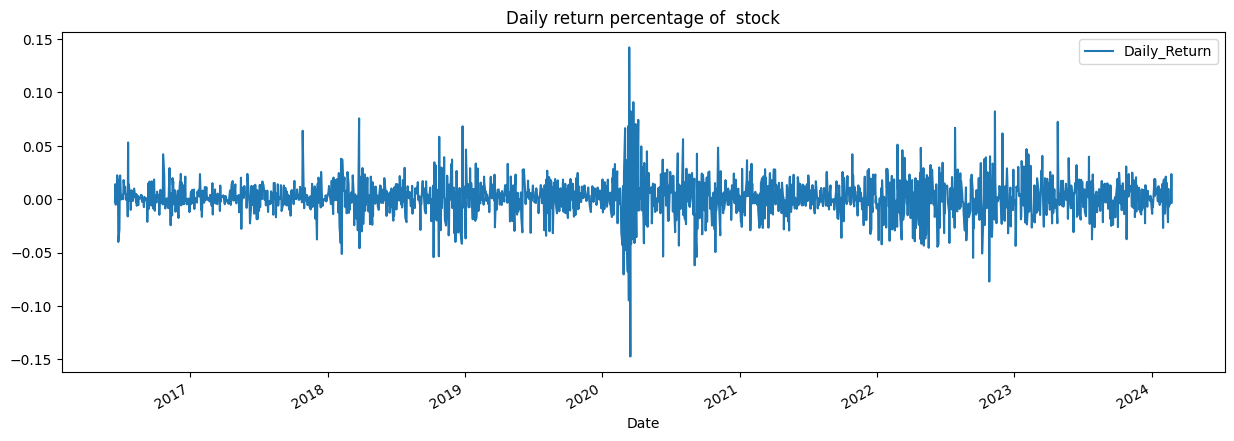

In [6]:
# use pct_change to find the percent change for each day
df['Daily_Return'] = df['Close'].pct_change()

df.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of  stock')
plt.show()

In [23]:

df2 = df.copy(deep=True)
scaler = MinMaxScaler(feature_range=(0,15)).fit(df2.Low.values.reshape(-1,1))
df2['Open'] = scaler.transform(df2.Open.values.reshape(-1,1))
df2['High'] = scaler.transform(df2.High.values.reshape(-1,1))
df2['Low'] = scaler.transform(df2.Low.values.reshape(-1,1))
df2['Close'] = scaler.transform(df2.Close.values.reshape(-1,1))
data = df2[['Open','High','Low', 'Close']].values
data.shape

(1909, 4)

In [24]:
data

array([[ 0.07366769,  0.0815888 ,  0.0605976 ,  0.07089528],
       [ 0.0689155 ,  0.08238159,  0.06535094,  0.06535094],
       [ 0.05861719,  0.09624303,  0.05822104,  0.09307447],
       ...,
       [14.63615194, 14.97890821, 14.63395533, 14.91738693],
       [15.05932333, 15.26497629, 14.81236384, 14.99912162],
       [15.03691197, 15.17709027, 15.        , 15.16786261]])

In [25]:
seq_len=11
sequences=[]
for index in range(len(data) - seq_len + 1): 
    sequences.append(data[index: index + seq_len])
sequences= np.array(sequences)

Splitting the Data We divide the entire dataset into three parts. 80% for the training set, 10% for the validation set and the remaining 10% for the test set:


In [26]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

valid_set_size = int(np.round(valid_set_size_percentage/100*sequences.shape[0]))  
test_set_size  = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - (valid_set_size + test_set_size)

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]
    
x_valid = sequences[train_set_size:train_set_size+valid_set_size,:-1,:]
y_valid = sequences[train_set_size:train_set_size+valid_set_size,-1,:]
    
x_test = sequences[train_set_size+valid_set_size:,:-1,:]
y_test = sequences[train_set_size+valid_set_size:,-1,:]

In [27]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

train_dataset = TensorDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

valid_dataset = TensorDataset(x_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [28]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = NeuralNetwork(4)

#push to cuda if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
# model = model.to(device)

In [29]:

summary(model, (4, ))

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  17,920
├─Linear: 1-2                            [-1, 4]                   260
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07


Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  17,920
├─Linear: 1-2                            [-1, 4]                   260
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07

In [30]:
optimizer = optim.Adam(model.parameters())
mse = nn.MSELoss()

In [31]:
def train(dataloader):
    epoch_loss = 0
    model.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y= batch
        pred = model(x)
        loss = mse(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

In [32]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = mse(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

In [33]:
n_epochs = 50
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):

    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'saved_weights.pt')

  
    print(f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

	Train Loss: 712.89551 | 	Val Loss: 22.18689

	Train Loss: 606.03756 | 	Val Loss: 14.79493

	Train Loss: 220.14888 | 	Val Loss: 6.29368

	Train Loss: 130.28982 | 	Val Loss: 2.46457

	Train Loss: 65.30976 | 	Val Loss: 1.00054

	Train Loss: 41.14365 | 	Val Loss: 0.61599

	Train Loss: 28.36855 | 	Val Loss: 0.72448

	Train Loss: 22.47622 | 	Val Loss: 1.02331

	Train Loss: 17.55372 | 	Val Loss: 0.69762

	Train Loss: 16.24617 | 	Val Loss: 0.89345

	Train Loss: 14.07771 | 	Val Loss: 0.59110

	Train Loss: 12.51281 | 	Val Loss: 1.84992

	Train Loss: 10.84085 | 	Val Loss: 1.57917

	Train Loss: 11.53973 | 	Val Loss: 0.91514

	Train Loss: 11.57491 | 	Val Loss: 0.67697

	Train Loss: 8.69518 | 	Val Loss: 0.74394

	Train Loss: 6.74414 | 	Val Loss: 0.48967

	Train Loss: 9.13541 | 	Val Loss: 1.63642

	Train Loss: 9.55742 | 	Val Loss: 0.86164

	Train Loss: 6.40094 | 	Val Loss: 0.48185

	Train Loss: 8.71962 | 	Val Loss: 1.16310

	Train Loss: 7.05865 | 	Val Loss: 1.14689

	Train Loss: 5.66272 | 	Val Loss:

In [34]:
model=torch.load('saved_weights.pt')

In [35]:
x_test= torch.tensor(x_test).float()

with torch.no_grad():
  y_test_pred = model(x_test)

y_test_pred = y_test_pred.numpy()[0]

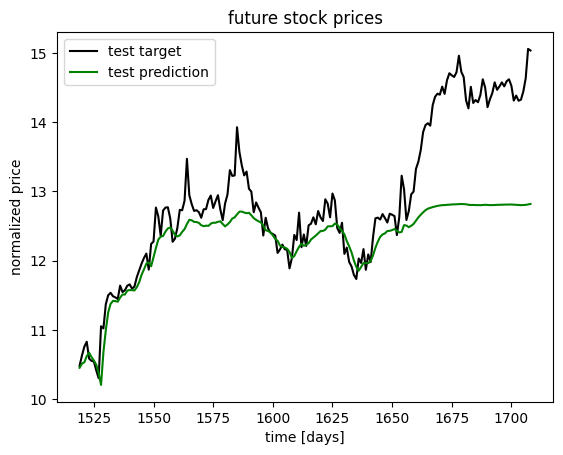

In [36]:
idx=0
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,idx], color='black', label='test target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,idx], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')

In [37]:
index_values = df[len(df) - len(y_test):].index
col_values = ['Open', 'Low', 'High', 'Close']
df_results = pd.DataFrame(data=y_test_pred, index=index_values, columns=col_values)

In [39]:

candlestick_trace = go.Candlestick(
    x=df_results.index,
    open=df_results['Open'],
    high=df_results['High'],
    low=df_results['Low'],
    close=df_results['Close'],
    name='Candlestick'
)


layout = go.Layout(
    title='MSFT Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)


fig = go.Figure(data=[candlestick_trace], layout=layout)


fig.update_layout(xaxis_rangeslider_visible=False)

fig.show()

In [40]:

last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()


PRED_DAYS = 10
with torch.no_grad():
    for i in range(PRED_DAYS):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]


pred_days = last_sequence.reshape(PRED_DAYS, 4).numpy()

pred_days = scaler.inverse_transform(pred_days)

df_pred = pd.DataFrame(
    data=pred_days,
    columns=['Open', 'High', 'Low', 'Close']
)

df_pred

,Open,High,Low,Close
0,335.105743,339.548370,330.759918,332.679657
1,333.653503,337.562469,329.042786,330.567566
2,332.406372,335.890320,327.632111,328.864502
3,331.181305,334.450684,326.326813,327.447876
4,329.903351,333.095581,325.035065,326.170563
5,328.531982,331.716400,323.698120,324.922791
6,327.080170,330.284180,322.314392,323.667694
7,325.635956,328.862366,320.955841,322.438812
8,324.359955,327.595337,319.755524,321.333893
9,323.352295,326.583008,318.795624,320.436096


In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

y_true = y_test
y_pred = y_test_pred

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
explained_variance = explained_variance_score(y_true, y_pred)

print("mae is:",mae)
print("explained_variance is:",explained_variance)
print("rmse is:",rmse)
print("mse is:",mse)
print("r2 is:", r2)

mae is: 0.6259327574147383
explained_variance is: 0.6202971105450784
rmse is: 0.9048821686756193
mse is: 0.818811739187092
r2 is: 0.3191615019239372
